Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [4]:
timeseries = df['Passengers'].values.astype('float32')
timeseries[:5]

array([112., 118., 132., 129., 121.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [5]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size

train = timeseries[:train_size]
test = timeseries[train_size:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 96
Test size: 48


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [8]:
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback)])
        y.append(dataset[i + lookback])
    X = np.array(X)
    y = np.array(y)

    return torch.tensor(X).float(), torch.tensor(y).float().view(-1, 1)

In [9]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [10]:
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [11]:
model = AirModel(hidden_size=50, num_layers=1)
test_input = torch.tensor([[[112.]]])  
test_output = model(test_input)
print("Тестовий вихід:", test_output)

Тестовий вихід: tensor([[[-0.2753]]], grad_fn=<ViewBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [12]:
train_ds = TensorDataset(X_train.unsqueeze(-1), y_train.unsqueeze(-1))
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [19]:
model = AirModel(hidden_size=50, num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses = []

for epoch in range(2000):
    model.train()
    total_loss = 0

    for xb, yb in train_dl:
        yb = yb.squeeze(-1)
        output = model(xb)
        loss = loss_fn(output[:, -1], yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    losses.append(total_loss / len(train_dl))

    # Валідація раз на 100 епох
    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train.unsqueeze(-1))[:, -1]
            test_pred = model(X_test.unsqueeze(-1))[:, -1]

            train_rmse = torch.sqrt(loss_fn(train_pred, y_train))
            test_rmse = torch.sqrt(loss_fn(test_pred, y_test))

        print(f"Epoch {epoch+1}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 100: train RMSE 75.5683, test RMSE 239.0491
Epoch 200: train RMSE 71.5967, test RMSE 222.5851
Epoch 300: train RMSE 71.1502, test RMSE 215.4743
Epoch 400: train RMSE 71.1494, test RMSE 215.2895
Epoch 500: train RMSE 71.1492, test RMSE 215.2228
Epoch 600: train RMSE 71.1498, test RMSE 215.3944
Epoch 700: train RMSE 71.1497, test RMSE 215.3765
Epoch 800: train RMSE 71.1494, test RMSE 214.9194
Epoch 900: train RMSE 71.3220, test RMSE 219.7452
Epoch 1000: train RMSE 71.1491, test RMSE 215.1078
Epoch 1100: train RMSE 71.1492, test RMSE 214.9983
Epoch 1200: train RMSE 71.1494, test RMSE 214.8988
Epoch 1300: train RMSE 71.1496, test RMSE 214.8656
Epoch 1400: train RMSE 71.1492, test RMSE 214.9869
Epoch 1500: train RMSE 71.1491, test RMSE 215.0949
Epoch 1600: train RMSE 71.1492, test RMSE 214.9893
Epoch 1700: train RMSE 71.1493, test RMSE 214.9657
Epoch 1800: train RMSE 71.1497, test RMSE 215.3704
Epoch 1900: train RMSE 71.1492, test RMSE 215.2004
Epoch 2000: train RMSE 71.1497, test RMS

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

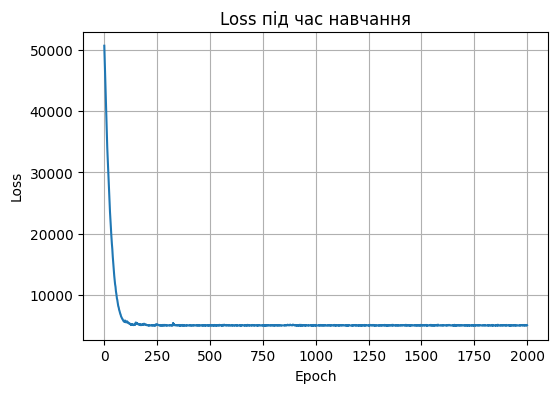

In [20]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Loss під час навчання")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

**Loss стабілізувався, отже, навчання відбулося, але RMSE на тестових даних залишився високим, що свідчить про слабке узагальнення.**

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

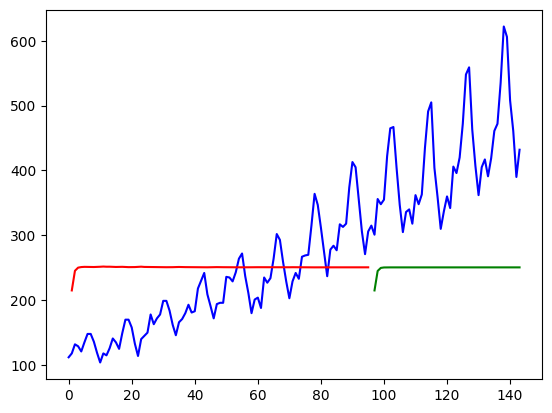

In [26]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**На графіку видно, що модель не передає сезонність, адже вихід стабільний і не слідує коливанням кількості пасажирів.**

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [22]:
model_100 = AirModel(hidden_size=100, num_layers=1)
optimizer_100 = torch.optim.Adam(model_100.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses_100 = []
for epoch in range(1000):
    model_100.train()
    total_loss = 0
    for xb, yb in train_dl:
        output = model_100(xb)
        loss = loss_fn(output[:, -1], yb)
        loss.backward()
        optimizer_100.step()
        optimizer_100.zero_grad()
        total_loss += loss.item()
    losses_100.append(total_loss / len(train_dl))
    
    # Валідація раз на 100 епох
    if (epoch + 1) % 100 == 0:
        model_100.eval()
        with torch.no_grad():
            train_pred = model_100(X_train.unsqueeze(-1))[:, -1]
            test_pred = model_100(X_test.unsqueeze(-1))[:, -1]

            train_rmse = torch.sqrt(loss_fn(train_pred, y_train))
            test_rmse = torch.sqrt(loss_fn(test_pred, y_test))

        print(f"Epoch {epoch+1}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 100: train RMSE 71.1498, test RMSE 215.4439
Epoch 200: train RMSE 71.1832, test RMSE 217.1739
Epoch 300: train RMSE 71.1490, test RMSE 214.8775
Epoch 400: train RMSE 71.1465, test RMSE 215.1234
Epoch 500: train RMSE 71.1487, test RMSE 215.0073
Epoch 600: train RMSE 71.1601, test RMSE 216.2756
Epoch 700: train RMSE 71.1493, test RMSE 214.9498
Epoch 800: train RMSE 71.1491, test RMSE 215.0164
Epoch 900: train RMSE 71.1495, test RMSE 215.3338
Epoch 1000: train RMSE 71.1495, test RMSE 215.3416


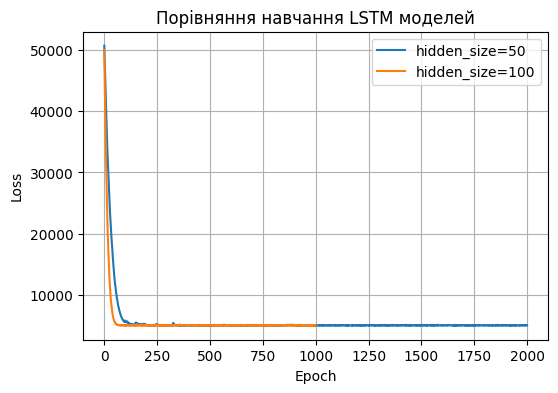

In [23]:
plt.figure(figsize=(6,4))
plt.plot(losses, label='hidden_size=50')
plt.plot(losses_100, label='hidden_size=100')
plt.title('Порівняння навчання LSTM моделей')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**На третьому графіку видно, що обидві криві втрат практично збігаються. Модель із 100 нейронами не дає суттєвого поліпшення, адже втрати майже однакові.**